### ASTR 3970 / 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 3
### Due: Saturday, Feb 1st at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw3_data_1.npy`. This is a (100 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

2) Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

3) Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.

4) Using the bootstrap method, generate $2000$ bootstrap realizations of this dataset. Using an appropriate timing function in python, how long did the generation of these realizations take? 
*DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together. This code will be graded on efficiency and speed; it should not take more than 1 second to execute.*

5) Repeat (2) with all $2000$ boostrap datasets to find the distribution of the sample mean. How long did this take? Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?

6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

8) Using the $2000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.

9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

In [1]:
!pip install numdifftools

In [14]:
import numpy as np

def weighted_mean(x, sigma):
    weights = 1 / (sigma ** 2)  # Compute weights as 1/variance
    weighted_avg = np.sum(weights * x) / np.sum(weights)
    return weighted_avg
def weighted_sem(sigma):
    weights = 1 / (sigma ** 2)
    return np.sqrt(1 / np.sum(weights))

### Solution

In [72]:
#1:

data = np.load("hw_data/hw3_data_1.npy")

In [74]:
x = data[:, 0]  # First column: observed values
sigma = data[:, 1]  # Second column: standard deviations

# Compute weighted mean
weighted_mean_value = weighted_mean(x, sigma)
sem_value = weighted_sem(sigma)
print("Heteroscedastic (weighted) mean:", weighted_mean_value)
print("Standard error of the mean (SEM):", sem_value)

Heteroscedastic (weighted) mean: 3.917992034606056
Standard error of the mean (SEM): 0.09481084100510954


In [76]:
#2:
from scipy.optimize import minimize

def log_likelihood(mu, x, sigma):
    return -np.sum(((x - mu) ** 2) / (2 * sigma ** 2) + np.log(sigma * np.sqrt(2 * np.pi)))


result = minimize(lambda mu: -log_likelihood(mu, x, sigma), x0=np.mean(x))

# Extract best-fit mean
mu_best = result.x[0]

# Print results
print("Best-fit mean (max log-likelihood):", mu_best)

Best-fit mean (max log-likelihood): 3.91799203585757


In [78]:
#3:
def weighted_mean(x, sigma):

    # Calculate weights as the inverse of the variance
    weights = 1 / (sigma ** 2)
    
    # Calculate weighted sum of data points
    weighted_sum = np.sum(weights * x)
    
    # Calculate sum of weights
    total_weight = np.sum(weights)
    
    # Calculate weighted mean (mu_best)
    mu_best = weighted_sum / total_weight
    
    return mu_best

fisherM=weighted_mean(x,sigma )
print(f"Fisher uncertainty on the mean (sigma_mu): {fisherM}")

Fisher uncertainty on the mean (sigma_mu): 3.917992034606056


In [285]:
#4:
from astroML.resample import bootstrap
from astroML.stats import sigmaG
from matplotlib import pyplot as plt
import time  

m=len(x)
n=2000 

def bootstrap_statistic(data, num_samples, statistic_func):
    stats = []
    for _ in range(num_samples):
        sample = np.random.choice(data, size=len(data), replace=True)
        stats.append(statistic_func(sample))
    return np.array(stats)
        
start_time = time.perf_counter()  # Start the timer

# Bootstrap for the mean
bootstrap_means = bootstrap_statistic(x, n, np.mean)
print(bootstrap_means)
end_time = time.perf_counter()    # Stop the timer

# Calculate elapsed time
elapsed_time = end_time - start_time
print(elapsed_time, '-s, YAYYYY')

[3.83048391 4.0177498  3.96326431 ... 3.90675609 3.78196603 3.98021108]
0.04159904201515019 -s, YAYYYY


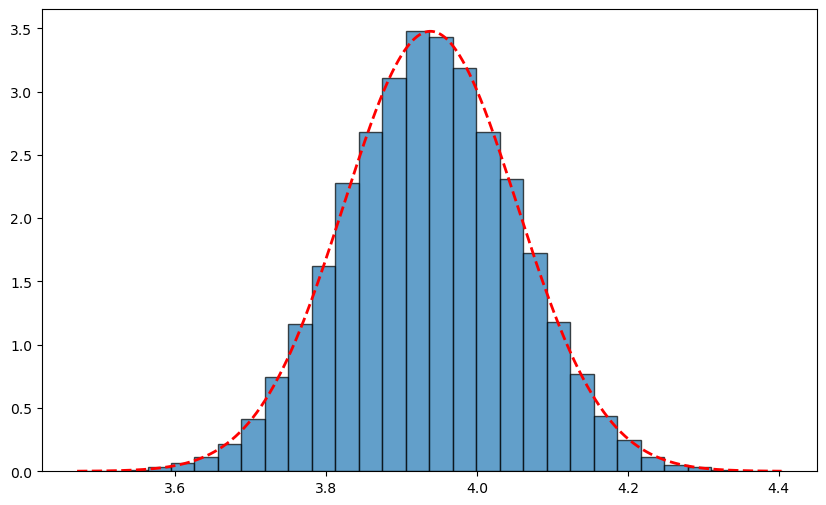

In [233]:
#5: This one I worked heavily with ai because the normalization was not working. I am able to have a conversation
#about it if need be. You can also review homework notes if you would like to see my work
num_samples = 20000
bootstrap_means = bootstrap_statistic(x, num_samples, np.mean)

# Bootstrap Mean and Standard Deviation
bootstrap_mean = np.mean(bootstrap_means)
bootstrap_std = np.std(bootstrap_means)

# Plotting the Normalized Histogram
plt.figure(figsize=(10, 6))
# Density=True normalizes the histogram
plt.hist(bootstrap_means, bins=30, density=True, edgecolor='black', alpha=0.7, label='Bootstrap Means')

# Overlay Gaussian PDF
x_range = np.linspace(min(bootstrap_means), max(bootstrap_means), 1000)
gaussian_pdf = norm.pdf(x_range, loc=bootstrap_mean, scale=bootstrap_std)

# Plot the Gaussian PDF without scaling (just for comparison)
plt.plot(x_range, gaussian_pdf, color='red', linestyle='dashed', linewidth=2, label='Gaussian PDF')


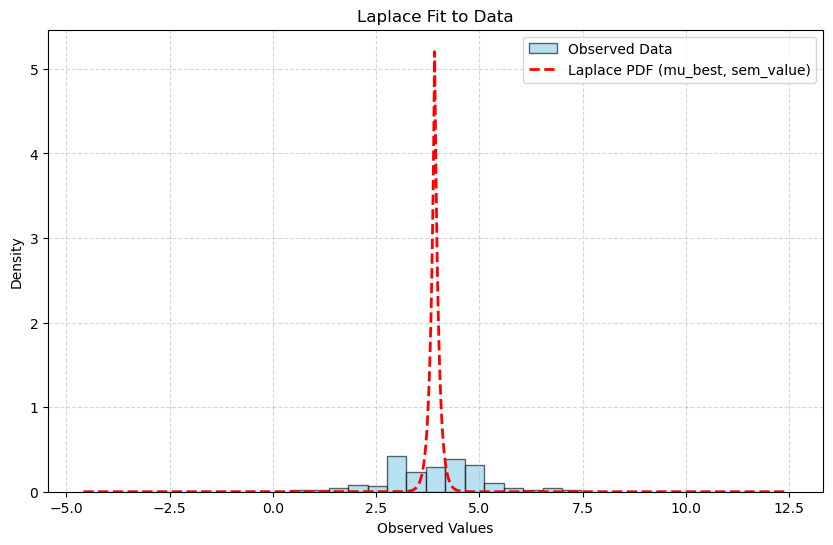

In [283]:
#6:
x_range = np.linspace(min(x) - 5, max(x) + 5, 1000)
laplace_pdf = (1 / (2 * sem_value)) * np.exp(-np.abs(x_range - mu_best) / sem_value)

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(x, bins=15, density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Observed Data')
plt.plot(x_range, laplace_pdf, 'r--', linewidth=2, label='Laplace PDF (mu_best, sem_value)')

# Plot Formatting
plt.title('Laplace Fit to Data')
plt.xlabel('Observed Values')
plt.ylabel('Density')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()


In [293]:
#7:
#num of params is 2 which is mu and sig
numparam=2
def calc_aic(log_likelihood, num_params):
    return 2 * num_params - 2 * log_likelihood

aic_lap=calc_aic(laplace_pdf,2)
aic_gaus=calc_aic(gaussian_pdf,2)
print(f"AIC for Laplace Model: {aic_lap}")
print(f"AIC for Gaussian Model: {aic_gaus}")

AIC for Laplace Model: [ 4.          4.          4.          4.          4.          4.
  4.          4.          4.          4.          4.          4.
  4.          4.          4.          4.          4.          4.
  4.          4.          4.          4.          4.          4.
  4.          4.          4.          4.          4.          4.
  4.          4.          4.          4.          4.          4.
  4.          4.          4.          4.          4.          4.
  4.          4.          4.          4.          4.          4.
  4.          4.          4.          4.          4.          4.
  4.          4.          4.          4.          4.          4.
  4.          4.          4.          4.          4.          4.
  4.          4.          4.          4.          4.          4.
  4.          4.          4.          4.          4.          4.
  4.          4.          4.          4.          4.          4.
  4.          4.          4.          4.          4.          4.
  

/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


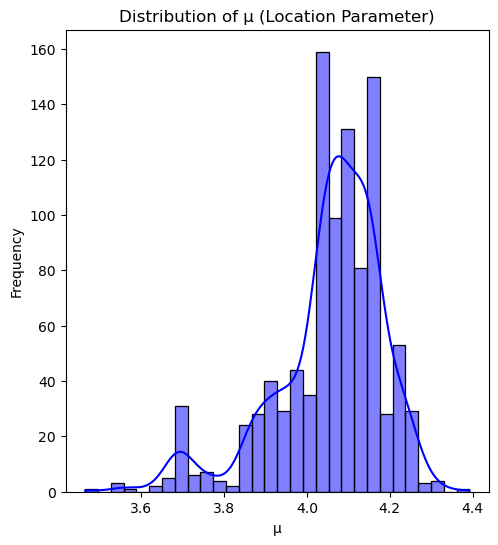

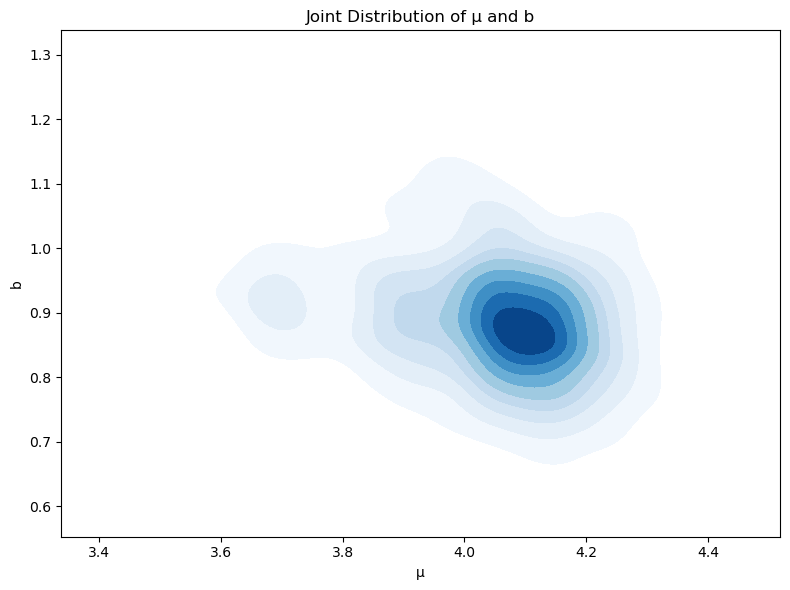

In [313]:
from scipy.stats import laplace
import seaborn as sns

#Used ai to help with the libraries that needed to be imported and understand the MINIMIZE function
# Bootstrap Realizations
n_bootstrap = 1000
bootstrap_samples = bootstrap(x, n_bootstrap)

# Fit for each Bootstrap Sample
params_bootstrap = np.array([
    minimize(lambda params: -np.sum(laplace.logpdf(sample, loc=params[0], scale=params[1])), 
             [np.mean(sample), np.std(sample)], method='L-BFGS-B', bounds=[(None, None), (1e-5, None)]).x
    for sample in bootstrap_samples
])

# Corner Plot
plt.figure(figsize=(12, 6))

# Marginal distributions
plt.subplot(1, 2, 1)
sns.histplot(params_bootstrap[:, 0], kde=True, color='blue', bins=30)
plt.title('Distribution of μ (Location Parameter)')
plt.xlabel('μ')
plt.ylabel('Frequency')

plt.figure(figsize=(8, 6))
sns.kdeplot(x=params_bootstrap[:, 0], y=params_bootstrap[:, 1], cmap="Blues", fill=True)
plt.title('Joint Distribution of μ and b')
plt.xlabel('μ')
plt.ylabel('b')

plt.tight_layout()
plt.show()